# Abstract   
  
## Purpose of Analysis  
유형별 임대주택 설계 시 단지 내 적정 주차 수요를 예측  
  
## Background
- 아파트 단지 내 필요한 주차대수는 ①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정하게 되어 있음.
- 정확한 ②장래주차수요의 산정을 필요.
- 현재 ②장래주차수요는 ‘주차원단위’와 ‘건축연면적’을 기초로 하여 산출
- ‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사 중. -> 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성 존재

# Library 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import rc
import seaborn as sns 
%matplotlib inline

plt.rc('font', family='AppleGothic') 
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(color_codes=True)

from glob import glob
import os, random, time, gc, warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor


# Data Load & Basic Handling

In [2]:
path = './data/'

# data load 
def load_dataset(path) : 
    train = pd.read_csv(path + 'train.csv')
    test = pd.read_csv(path + 'test.csv')
    age_gender = pd.read_csv(path + 'age_gender_info.csv')
    sample_submission = pd.read_csv(path + 'sample_submission.csv')
    return train, test, age_gender, sample_submission

%time train, test, age_gender, sample_submission = load_dataset(path)

CPU times: user 32.3 ms, sys: 7.7 ms, total: 40 ms
Wall time: 60.3 ms


## Shape  

In [3]:
print("==== Dataset Shape ====")
print(f"train set : {train.shape}")
print(f"test set : {test.shape}")
print(f"Age_Gender set : {age_gender.shape}")
print()
print("==== Info - train set ====")
print(train.info())
print()
print("==== Info - test set ====")
print(test.info())
print()
print("==== Info - age_gender set ====")
print(age_gender.info())

==== Dataset Shape ====
train set : (2952, 15)
test set : (1022, 14)
Age_Gender set : (16, 23)

==== Info - train set ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11

## Missing values  
- 자격 유형   
- 임대보조금  
- 임대료  
- 도보 10분거리 내 지하철역 수  
- 도보 10분거리 내 버정 수  

In [4]:
# train + test = df 
df = pd.concat([train, test])

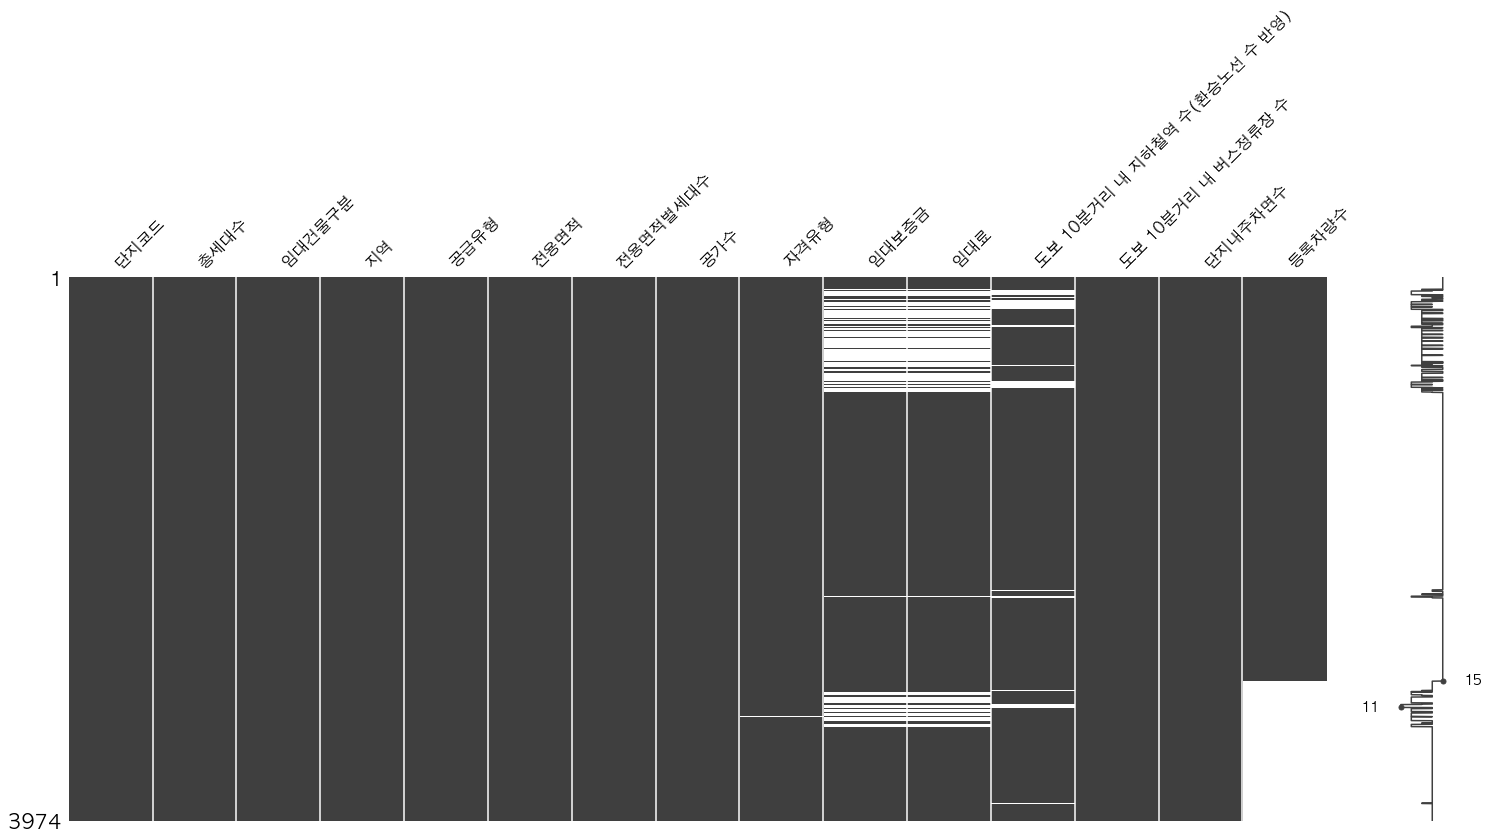

In [5]:
msno.matrix(df);

In [6]:
#컬럼명 바꾸기.. 

train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

df.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

### 자격유형  
- C2411 : A로  
- C2253 : C로.  
  
**동일 단지코드라도 자격유형이 여러 개 있는 경우가 있음 (아래 임대료, 임대보증금 파트 참고) :**  
**동일 단지코드지만 알파벳 순서가 앞인 경우가 뒤의 경우보다 많은 임대보증금과 임대료를 지불하고 있는 경우 1건 존재**  


In [7]:
df[df['자격유형'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0,NaN
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0,NaN


In [8]:
# df[df['단지코드']=='C2411']  : A
df.loc[(df['단지코드']=='C2411'),'자격유형']='A'

In [9]:
# df[df['단지코드']=='C2253']  : 공급유형이 영구임대인 경우 C로 추론됨 
df.loc[(df['단지코드']=='C2253') & (df['공급유형']=='영구임대'), '자격유형']='C'

### 임대료, 임대보증금   
- 결측치를 채울 수 없음.  
- 결측치가 모두 '상가'인 경우이므로 '아파트'인 경우와 달리 임대료와 임대보증금 정보가 중요하지 않을 수 있음. 아파트는 임대료와 임대보증금이 가구 소득의 단서로 활용될 수 있는 반면 상가는 그렇지 않으므로.  
- 따라서 단순하게 0 으로 채워도 무방할 듯 

In [10]:
df[df['임대료'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
88,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
89,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
90,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
91,C1925,601,상가,강원도,임대상가,72.16,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
101,C1874,619,상가,충청남도,임대상가,12.62,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,C1729,627,상가,강원도,임대상가,32.46,1,0.0,D,NaN,NaN,0.0,5.0,131.0,NaN
329,C1729,627,상가,강원도,임대상가,34.86,1,0.0,D,NaN,NaN,0.0,5.0,131.0,NaN
330,C1729,627,상가,강원도,임대상가,35.76,1,0.0,D,NaN,NaN,0.0,5.0,131.0,NaN
331,C1729,627,상가,강원도,임대상가,50.08,1,0.0,D,NaN,NaN,0.0,5.0,131.0,NaN


In [11]:
df[df['단지코드']=='C1925']
# 전용면적별 세대수(600) = 총세대수(601) 이므로 행이 동일하게 보일지라도 드롭하면 X 
# 이 경우 주상복합으로 추론됨. 
# 이렇게 '임대건물구분'에 아파트+상가 = 주상복합으로 새 labeling해야 하지 않을까? 


# 임대료와 임대보증금이 NaN인 이유는 아마도 아직 세입자가 없기 때문인 것으로 추정됨.  
# 현재 공실은 9개인데 
# - 이 중 4개는 상가에서 : 32.10에서 3개, 72.16에서 1개
# - 나머지 5개는 아파트에서. 

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
86,C1925,601,아파트,강원도,영구임대,26.37,298,9.0,C,8052000,130850,0.0,4.0,117.0,75.0
87,C1925,601,아파트,강원도,영구임대,31.32,298,9.0,C,9174000,144460,0.0,4.0,117.0,75.0
88,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
89,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
90,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
91,C1925,601,상가,강원도,임대상가,72.16,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0


In [12]:
#임대상가 = 상가
print('== 임대건물이 "상가"인 경우와 공급유형이 "임대상가"인 경우 갯수 비교 ==')
print('상가', df[df['임대건물구분']=='상가'].shape[0])
print('임대상가', df[df['공급유형']=='임대상가'].shape[0])
print()
print('결론 : 상가=임대상가')

== 임대건물이 "상가"인 경우와 공급유형이 "임대상가"인 경우 갯수 비교 ==
상가 739
임대상가 739

결론 : 상가=임대상가


In [13]:
#임대상가 중 자격유형이 D인 경우의 임대보증금과 임대료는 모두 결측치임. 
print('==== 임대상가 중 자격 유형이 "D"인 경우 임대보증금이 결측치인 경우 ====')
print(df[(df['공급유형']=='임대상가')&(df['자격유형']=='D')]['임대보증금'].isnull().sum())
print()

#임대 상가의 자격유형은 모두 D이며 임대보증금과 임대료가 모두 나와 있지 않음 
print('==== 임대상가의 자격유형 ====')
print(df[df['공급유형']=='임대상가']['자격유형'].value_counts())
print()
print('결론 : 임대 상가의 전용면적별 임대보증금과 임대료는 추론 불가능')

==== 임대상가 중 자격 유형이 "D"인 경우 임대보증금이 결측치인 경우 ====
739

==== 임대상가의 자격유형 ====
D    739
Name: 자격유형, dtype: int64

결론 : 임대 상가의 전용면적별 임대보증금과 임대료는 추론 불가능


In [14]:
# 상가의 경우 아파트와 달리 임대보증금 및 임대료는 크게 중요한 정보가 아닐 것으로 사료됨. 따라서 단순 0으로 채움.

df.loc[df['공급유형']=='임대상가', ['임대보증금','임대료']]=0
df[(df['공급유형']=='임대상가')&(df['자격유형']=='D')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
88,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,0,0,0.0,4.0,117.0,75.0
89,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,0,0,0.0,4.0,117.0,75.0
90,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,0,0,0.0,4.0,117.0,75.0
91,C1925,601,상가,강원도,임대상가,72.16,1,9.0,D,0,0,0.0,4.0,117.0,75.0
101,C1874,619,상가,충청남도,임대상가,12.62,1,2.0,D,0,0,NaN,2.0,97.0,62.0


In [15]:
# 상가 외 아파트의 임대보증금 및 임대료가 결측치인 경우가 있음 
df[df['임대보증금'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2331,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2332,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2333,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2334,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2335,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2336,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2337,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0,NaN
77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0,NaN
79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27.0,D,NaN,NaN,2.0,5.0,428.0,NaN


In [16]:
# 위의 경우는 공급유형 혹은 임대건물구분, 전용면적이 같은 경우를 찾아서 결측치를 채우기를 시도. 

# 그 전에 
# 임대보증금과 임대료 데이터 타입이 object이므로 이를 int로 바꿔준다. 결측치 0처리 -> int로 변경
# 임대보증금과 임대료가 '-'로 기록된 부분도 0으로 대체한다. 
df['임대보증금'].fillna(0, inplace=True)
df['임대료'].fillna(0, inplace=True)
df['임대보증금'].replace('-',0, inplace=True)
df['임대료'].replace('-',0, inplace=True)
df['임대보증금']=df['임대보증금'].astype(int)
df['임대료']=df['임대료'].astype(int)

In [17]:
##################################################
#   단지코드 C1350의 경우
##################################################

# 공급유형으로 조건을 걸면 결측치가 있는 위의 레코드 밖에 나오지 않음. 따라서 대신 임대건물구분=아파트 로 조건을 검 
# 지역까지 조건을 걸면 결측치가 있는 위의 레코드 밖에 나오지 않음. 따라서 지역 조건은 제외 

print('=== 전용면적 70이상 아파트의 임대보증금 평균 (서울시 포함)')
print(df[(df['임대건물구분']=='아파트')&(df['전용면적']>=70)].groupby('단지코드')['임대보증금'].mean().mean())
print()
print('=== 전용면적 70이상 아파트의 임대보증금 평균 (서울시 제외)')
print(df[(df['임대건물구분']=='아파트')&(df['전용면적']>=70)&(df['지역']!='서울특별시')].groupby('단지코드')['임대보증금'].mean().mean())


=== 전용면적 70이상 아파트의 임대보증금 평균 (서울시 포함)
57099197.45564893

=== 전용면적 70이상 아파트의 임대보증금 평균 (서울시 제외)
50359082.69329237


In [18]:
print('=== 전용면적 70이상 아파트의 임대료 평균 (서울시 포함)')
print(df[(df['임대건물구분']=='아파트')&(df['전용면적']>=70)].groupby('단지코드')['임대료'].mean().mean())
print()
print('=== 전용면적 70이상 아파트의 임대료 평균 (서울시 제외)')
print(df[(df['임대건물구분']=='아파트')&(df['전용면적']>=70)&(df['지역']!='서울특별시')].groupby('단지코드')['임대료'].mean().mean())


=== 전용면적 70이상 아파트의 임대료 평균 (서울시 포함)
525804.2959850607

=== 전용면적 70이상 아파트의 임대료 평균 (서울시 제외)
522402.5665642601


In [19]:
# 혹시나 해서 서울시를 포함/제외의 경우에 임대 보증금 및 임대료에 평균 차이가 있는지 살펴보았으나 큰 차이가 없음. 
# 따라서 포함한 평균으로 결측치를 채워주기로 한다. 

df.loc[df['단지코드']=='C1350', ['임대보증금', '임대료']]= 57099197, 525804

In [20]:
##################################################
#     단지코드 C1006의 경우 
##################################################

# 공급유형, 전용면적, 지역 조건을 걸었을 때 동일한 경우 존재. 

df[(df['공급유형']=='영구임대')&(df['지역']=='대전광역시')&(df['전용면적']==26.37)]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
153,C2621,1396,아파트,대전광역시,영구임대,26.37,890,26.0,C,5787000,79980,1.0,4.0,277.0,133.0
154,C2621,1396,아파트,대전광역시,영구임대,26.37,141,26.0,C,5787000,79980,1.0,4.0,277.0,133.0
155,C2621,1396,아파트,대전광역시,영구임대,26.37,20,26.0,C,5787000,79980,1.0,4.0,277.0,133.0
156,C2621,1396,아파트,대전광역시,영구임대,26.37,20,26.0,C,5787000,79980,1.0,4.0,277.0,133.0
176,C1616,1507,아파트,대전광역시,영구임대,26.37,588,1.0,C,5787000,79980,NaN,2.0,407.0,98.0
215,C2258,965,아파트,대전광역시,영구임대,26.37,588,13.0,C,5787000,79980,NaN,3.0,287.0,78.0
241,C2038,785,아파트,대전광역시,영구임대,26.37,588,7.0,C,5787000,79980,1.0,10.0,150.0,108.0
261,C1859,2424,아파트,대전광역시,영구임대,26.37,1865,1.0,C,5787000,79980,1.0,4.0,487.0,116.0
262,C1859,2424,아파트,대전광역시,영구임대,26.37,10,1.0,C,5787000,79980,1.0,4.0,487.0,116.0
263,C1859,2424,아파트,대전광역시,영구임대,26.37,10,1.0,C,5787000,79980,1.0,4.0,487.0,116.0


In [21]:
# 다만 자격유형 C가 아니라 D에 해당하는 경우인데, 자격 유형에 따라 보증금과 임대료가 달라지는지 다른 케이스를 확인해 보기로 함 

temp=df[df['공급유형']=='영구임대'].groupby('단지코드')['자격유형'].nunique()>1
temp[temp.values==True]

단지코드
C1006    True
C1616    True
C2132    True
C2255    True
C2507    True
Name: 자격유형, dtype: bool

In [22]:
display(df[(df['단지코드']=='C1616')&(df['공급유형']=='영구임대')])
display(df[(df['단지코드']=='C2132')&(df['공급유형']=='영구임대')])
display(df[(df['단지코드']=='C2255')&(df['공급유형']=='영구임대')])
display(df[(df['단지코드']=='C2507')&(df['공급유형']=='영구임대')])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
176,C1616,1507,아파트,대전광역시,영구임대,26.37,588,1.0,C,5787000,79980,NaN,2.0,407.0,98.0
177,C1616,1507,아파트,대전광역시,영구임대,31.32,450,1.0,C,6873000,94990,NaN,2.0,407.0,98.0
178,C1616,1507,아파트,대전광역시,영구임대,40.32,450,1.0,E,54040000,28140,NaN,2.0,407.0,98.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
522,C2132,2428,아파트,부산광역시,영구임대,26.37,358,1.0,F,3912000,67260,0.0,1.0,756.0,359.0
523,C2132,2428,아파트,부산광역시,영구임대,26.37,1192,1.0,F,3912000,67260,0.0,1.0,756.0,359.0
524,C2132,2428,아파트,부산광역시,영구임대,31.32,239,1.0,C,6873000,94990,0.0,1.0,756.0,359.0
525,C2132,2428,아파트,부산광역시,영구임대,31.32,596,1.0,F,4646000,79890,0.0,1.0,756.0,359.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2053,C2255,560,아파트,충청남도,영구임대,23.93,34,2.0,E,31980200,16650,0.0,2.0,400.0,410.0
2054,C2255,560,아파트,충청남도,영구임대,26.67,66,2.0,I,5514000,63280,0.0,2.0,400.0,410.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2484,C2507,1454,아파트,경기도,영구임대,21.72,238,4.0,I,7794000,71320,0.0,4.0,880.0,763.0
2485,C2507,1454,아파트,경기도,영구임대,26.79,30,4.0,I,9500000,87050,0.0,4.0,880.0,763.0
2486,C2507,1454,아파트,경기도,영구임대,26.81,146,4.0,I,9500000,87050,0.0,4.0,880.0,763.0
2487,C2507,1454,아파트,경기도,영구임대,29.62,15,4.0,A,13533000,162390,0.0,4.0,880.0,763.0
2488,C2507,1454,아파트,경기도,영구임대,29.72,109,4.0,A,13533000,162390,0.0,4.0,880.0,763.0


In [23]:
# 단지코드 C2132에서 같은 면적이지만 자격유형 C가 F보다 임대보증금 및 임대료를 더 높게 지불
# 이로 말미암아 자격 유형에 따른 소득 수준은 알파벳 앞이 뒤보다 더 크다고 추론.
# 즉 같은 면적이라도 자격 유형에 따라 임대보증금 및 임대료가 달라짐 


# C1006의 임대 보증금 및 임대료를 채우기 위해 아파트 한정 전용면적 26 이상 30미만 평균 임대보증금 및 임대료를 알아보기로 함 
# 자격유형=D를 조건으로 걸었을 경우 해당 경우를 결측치가 있는 경우를 제외하고는 찾을 수 없으므로 제외. 

print('=== 아파트 전용면적 26이상 30미만인 평균 임대보증금 ===')
print(df[(df['임대건물구분']=='아파트')&(df['전용면적']>=26)&(df['전용면적']<30)&(df['임대보증금']!=0)]\
.groupby('단지코드')['임대보증금'].mean().mean())
print()
print('=== 아파트 전용면적 26이상 30미만인 평균 임대료 ===')
print(df[(df['임대건물구분']=='아파트')&(df['전용면적']>=26)&(df['전용면적']<30)&(df['임대료']!=0)]\
.groupby('단지코드')['임대료'].mean().mean())


=== 아파트 전용면적 26이상 30미만인 평균 임대보증금 ===
15068626.29272568

=== 아파트 전용면적 26이상 30미만인 평균 임대료 ===
114262.03286590711


In [24]:
df.loc[(df['단지코드']=='C1006')&(df['임대건물구분']=='아파트')&(df['자격유형']=='D'),['임대보증금', '임대료'] ]= 15068626, 114262
df.loc[(df['단지코드']=='C1006')&(df['임대건물구분']=='상가')&(df['자격유형']=='D'),['임대보증금', '임대료'] ]= 0, 0

In [25]:
df[(df['단지코드']=='C1006')].head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
73,C1006,1505,아파트,대전광역시,영구임대,26.37,358,27.0,C,5787000,79980,2.0,5.0,428.0,NaN
74,C1006,1505,아파트,대전광역시,영구임대,26.37,229,27.0,C,5787000,79980,2.0,5.0,428.0,NaN
75,C1006,1505,아파트,대전광역시,영구임대,26.37,574,27.0,C,5787000,79980,2.0,5.0,428.0,NaN
76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,15068626,114262,2.0,5.0,428.0,NaN
77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,15068626,114262,2.0,5.0,428.0,NaN
78,C1006,1505,아파트,대전광역시,영구임대,31.32,298,27.0,C,6873000,94990,2.0,5.0,428.0,NaN
79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27.0,D,15068626,114262,2.0,5.0,428.0,NaN
80,C1006,1505,상가,대전광역시,임대상가,38.00,1,27.0,D,0,0,2.0,5.0,428.0,NaN
81,C1006,1505,상가,대전광역시,임대상가,38.00,1,27.0,D,0,0,2.0,5.0,428.0,NaN
82,C1006,1505,상가,대전광역시,임대상가,37.26,1,27.0,D,0,0,2.0,5.0,428.0,NaN


### 도보 10분내 지하철역, 버정  
- 결측값을 채울 수 있을 것으로 보이지 않음.  
- 드롭할 수는 없으므로 0 으로 대체. 

In [26]:
print('=== 지하철 컬럼 값이 null인 단지 ===')
print()
print(df[df['지하철'].isnull()]['단지코드'].unique().tolist())
print()
print('총 갯수 : ',df[df['지하철'].isnull()]['단지코드'].nunique() )

=== 지하철 컬럼 값이 null인 단지 ===

['C1312', 'C1874', 'C1424', 'C2100', 'C2520', 'C1616', 'C1704', 'C2258', 'C1068', 'C1983', 'C2216', 'C2644', 'C1005', 'C1004', 'C1875', 'C2156', 'C1175', 'C2583', 'C1649', 'C1350', 'C1472', 'C1083', 'C2177', 'C1318', 'C1327']

총 갯수 :  25


In [27]:
print('=== 버스 컬럼 값이 null인 단지 ===')
print()
print(df[df['버스'].isnull()]['단지코드'].unique().tolist())
print()
print('총 갯수 : ',df[df['버스'].isnull()]['단지코드'].nunique() )

=== 버스 컬럼 값이 null인 단지 ===

['C1649']

총 갯수 :  1


In [28]:
df['지하철'].fillna(0, inplace=True)
df['버스'].fillna(0, inplace=True)

### 결측값 처리 최종 확인

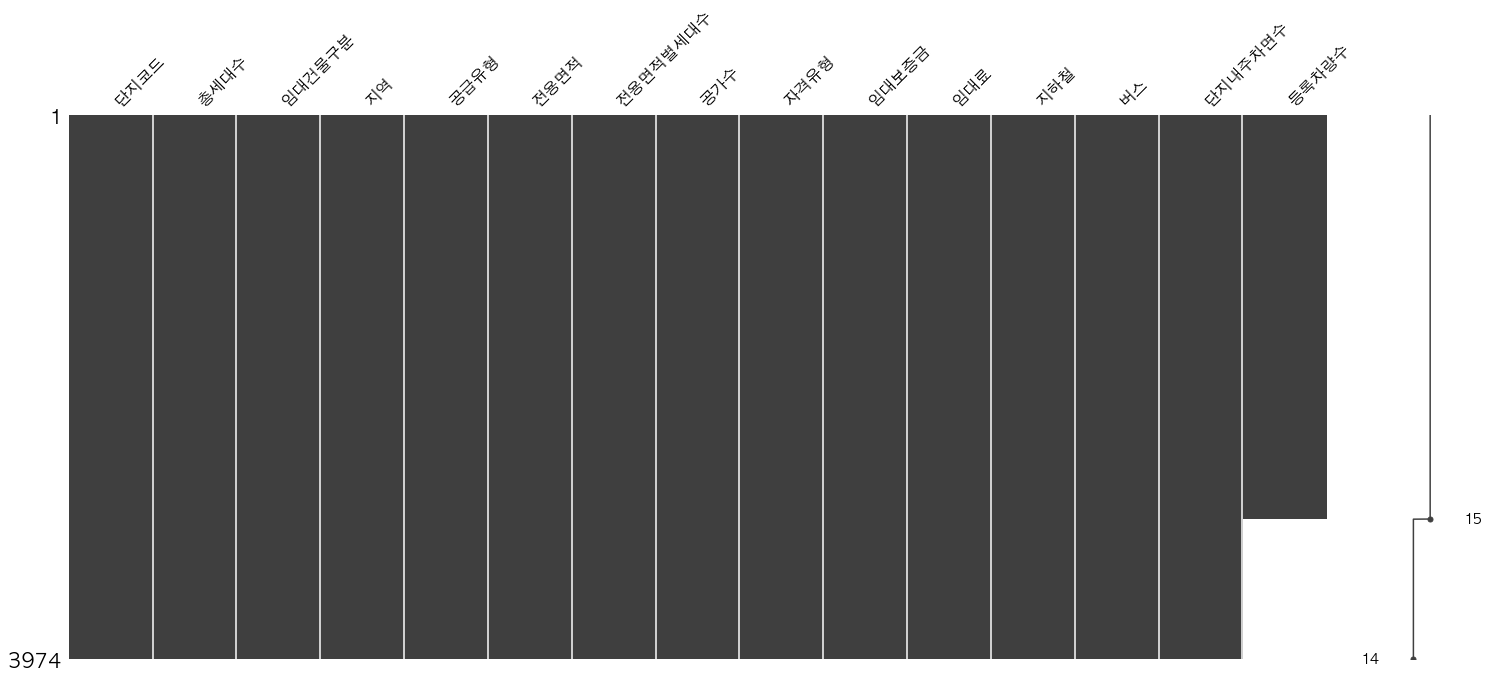

In [29]:
msno.matrix(df);

In [80]:
df.isnull().sum()

단지코드           0
총세대수           0
임대건물구분         0
지역             0
공급유형           0
전용면적           0
전용면적별세대수       0
공가수            0
자격유형           0
임대보증금          0
임대료            0
지하철            0
버스             0
단지내주차면수        0
등록차량수       1022
면적_유형          0
dtype: int64

# checklists   
## 공급유형  
- 단지코드가 동일하지만 임대건물 구분이 아파트와 상가 두 개인 경우 존재 = 주상복합건물로 추정 
- 이 경우 임대건물구분을 새롭게 라벨링할 필요가 있어보임 =>'주상복합' 

In [32]:
temp=df.groupby('단지코드')['공급유형'].nunique()>1
temp_list=temp[temp==True].index
temp_list

Index(['C1004', 'C1006', 'C1039', 'C1056', 'C1109', 'C1147', 'C1206', 'C1258',
       'C1267', 'C1341', 'C1344', 'C1350', 'C1363', 'C1439', 'C1451', 'C1476',
       'C1616', 'C1698', 'C1704', 'C1722', 'C1724', 'C1729', 'C1775', 'C1790',
       'C1812', 'C1849', 'C1859', 'C1874', 'C1875', 'C1899', 'C1925', 'C1968',
       'C1969', 'C1983', 'C2033', 'C2034', 'C2038', 'C2085', 'C2091', 'C2109',
       'C2113', 'C2131', 'C2132', 'C2135', 'C2177', 'C2186', 'C2190', 'C2212',
       'C2253', 'C2255', 'C2258', 'C2289', 'C2310', 'C2314', 'C2352', 'C2359',
       'C2393', 'C2416', 'C2430', 'C2453', 'C2507', 'C2508', 'C2531', 'C2539',
       'C2571', 'C2583', 'C2597', 'C2618', 'C2621', 'C2627', 'C2644', 'C2659',
       'C2676', 'C2688'],
      dtype='object', name='단지코드')

In [33]:
for tl in temp_list : 
    df.loc[df['단지코드']==tl, '임대건물구분']='주상복합'

In [34]:
# 확인
df[df['단지코드']=='C1004'].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
764,C1004,521,주상복합,충청남도,영구임대,39.30,240,3.0,C,4682000,104180,0.0,2.0,153.0,93.0
765,C1004,521,주상복합,충청남도,영구임대,39.69,264,3.0,C,4728000,105210,0.0,2.0,153.0,93.0
766,C1004,521,주상복합,충청남도,임대상가,19.00,1,3.0,D,0,0,0.0,2.0,153.0,93.0
767,C1004,521,주상복합,충청남도,임대상가,14.10,1,3.0,D,0,0,0.0,2.0,153.0,93.0
768,C1004,521,주상복합,충청남도,임대상가,19.31,1,3.0,D,0,0,0.0,2.0,153.0,93.0


In [47]:
print(f'총 {df[df["임대건물구분"]=="주상복합"]["단지코드"].nunique()}개의 단지가 "주상복합"으로 구분됨')

총 74개의 단지가 "주상복합"으로 구분됨


# 최종 Dataset 

In [48]:
df.to_csv('./df_final.csv')

# Renew Dataset by pivot()- 단지별  
- 데이콘 주최측이 올려놓은 피벗 변환은 몇 개의 컬럼이 빠져있고, 자격유형을 고려하지 않은 채 전용면적만으로 진행함  
- 그러나 같은 전용 면적이라도 자격 유형에 따라 가구의 소득 수준에 차이가 있다고 추론되므로 **전용 면적에 자격 유형까지 고려하여 피벗**을 적용  
  
<1차>  
- 그 결과 573 x 1052 의 데이터셋이 도출됨   
  
<2차>  
- 컬럼 수가 너무 많아져 Overfitting이 발생함.  
- 따라서 전용면적수를 반올림하여 계산하여 컬럼수 조정 시도 


In [49]:
df.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [51]:
# 전용면적+자격유형을 붙여 새로운 컬럼 만들기 : [면적_유형]
# df['면적_유형']=df['전용면적'].astype(str)+df['자격유형']
# df.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,면적_유형
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,39.72A
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,39.72A
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,51.93A


## 1차 

In [56]:
# columns = ['단지코드','총세대수', '임대건물구분','지역', '공가수', '자격유형', \
#            '공급유형','단지내주차면수','임대보증금','임대료', '지하철', '버스']
# target = '등록차량수'
# area_type_columns = []
# for area_type in tqdm(df['면적_유형'].unique()):
#     area_type_columns.append(area_type)

100%|██████████| 1039/1039 [00:00<00:00, 652964.02it/s]


In [65]:
# df_new = pd.DataFrame()

# for i, code in tqdm(enumerate(df['단지코드'].unique())):
#     temp = df[df['단지코드']==code]
#     temp.index = range(temp.shape[0])
#     for col in columns:
#         df_new.loc[i, col] = temp.loc[0, col]
    
#     for col in area_type_columns:
#         df_new.loc[i, col] = temp[temp['면적_유형']==col]['전용면적별세대수'].sum()
    
#     df_new.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']

573it [09:50,  1.03s/it]


In [70]:
# print(df_new.shape)
# print(df_new['단지코드'].count())
# print(df['단지코드'].nunique())

(573, 1052)
573
573


In [87]:
# df_new.to_csv('./df_pivot.csv')
df_new=pd.read_csv('df_pivot.csv', index_col=0)
display(df_new.head(3))
print('='*80)
print(f'피벗한 dataset 구조 : {df_new.shape}')
print('='*80)
print(f'결측치 여부 확인 : \n{df_new.isnull().sum()}')

,단지코드,총세대수,임대건물구분,지역,공가수,자격유형,공급유형,단지내주차면수,임대보증금,임대료,...,24.99H,46.72H,22.86C,16.94L,26.85L,36.77L,29.19H,39.45H,46.23H,등록차량수
0,C2483,900.0,아파트,경상북도,38.0,A,국민임대,1425.0,15667000.0,103680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,아파트,경상남도,17.0,A,국민임대,624.0,9216000.0,82940.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,아파트,대전광역시,13.0,A,국민임대,1285.0,15620000.0,127350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0


피벗한 dataset 구조 : (573, 1052)
결측치 여부 확인 : 
단지코드        0
총세대수        0
임대건물구분      0
지역          0
공가수         0
         ... 
36.77L      0
29.19H      0
39.45H      0
46.23H      0
등록차량수     150
Length: 1052, dtype: int64


In [90]:
#split train, test 
train=df_new[~df_new['등록차량수'].isnull()]
test=df_new[df_new['등록차량수'].isnull()].drop('등록차량수', 1)

In [94]:
print('train set: ',train.shape)
print('test set: ', test.shape)

train set:  (423, 1052)
test set:  (150, 1051)


## 2차 : 전용면적수 반올림  후 피벗 

In [444]:
df['전용면적']=round(df['전용면적'], 0)
df['면적_유형']=df['전용면적'].astype(str)+df['자격유형']
df.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,면적_유형,평수
0,C2483,900,아파트,경상북도,국민임대,40.0,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,40.0A,12.015300
1,C2483,900,아파트,경상북도,국민임대,40.0,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,40.0A,12.015300
2,C2483,900,아파트,경상북도,국민임대,52.0,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,52.0A,15.708825


In [455]:
columns = ['단지코드','총세대수', '임대건물구분','지역', '공가수', '자격유형', \
           '공급유형','단지내주차면수','임대보증금','임대료', '지하철', '버스']
target = '등록차량수'
area_type_columns = []
for area_type in tqdm(df['면적_유형'].unique()):
    area_type_columns.append(area_type)

df_new = pd.DataFrame()

for i, code in tqdm(enumerate(df['단지코드'].unique())):
    temp = df[df['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        df_new.loc[i, col] = temp.loc[0, col]
    
    for col in area_type_columns:
        df_new.loc[i, col] = temp[temp['면적_유형']==col]['전용면적별세대수'].sum()
    
    df_new.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']

100%|██████████| 207/207 [00:00<00:00, 561228.78it/s]
573it [02:31,  3.77it/s]


In [456]:
df_new.head(3)

,단지코드,총세대수,임대건물구분,지역,공가수,자격유형,공급유형,단지내주차면수,임대보증금,임대료,...,21.0J,23.0J,19.0J,34.0J,38.0J,20.0C,34.0C,23.0C,39.0H,등록차량수
0,C2483,900.0,아파트,경상북도,38.0,A,국민임대,1425.0,15667000.0,103680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,아파트,경상남도,17.0,A,국민임대,624.0,9216000.0,82940.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,아파트,대전광역시,13.0,A,국민임대,1285.0,15620000.0,127350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0


In [457]:
df_new.to_csv('./df_pivot_2.csv')
df_new=pd.read_csv('df_pivot_2.csv', index_col=0)
display(df_new.head(3))
print('='*80)
print(f'피벗한 dataset 구조 : {df_new.shape}')
print('='*80)
print(f'결측치 여부 확인 : \n{df_new.isnull().sum()}')

,단지코드,총세대수,임대건물구분,지역,공가수,자격유형,공급유형,단지내주차면수,임대보증금,임대료,...,21.0J,23.0J,19.0J,34.0J,38.0J,20.0C,34.0C,23.0C,39.0H,등록차량수
0,C2483,900.0,아파트,경상북도,38.0,A,국민임대,1425.0,15667000.0,103680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,아파트,경상남도,17.0,A,국민임대,624.0,9216000.0,82940.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,아파트,대전광역시,13.0,A,국민임대,1285.0,15620000.0,127350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0


피벗한 dataset 구조 : (573, 220)
결측치 여부 확인 : 
단지코드        0
총세대수        0
임대건물구분      0
지역          0
공가수         0
         ... 
20.0C       0
34.0C       0
23.0C       0
39.0H       0
등록차량수     150
Length: 220, dtype: int64


In [458]:
train=df_new[~df_new['등록차량수'].isnull()]
test=df_new[df_new['등록차량수'].isnull()].drop('등록차량수', 1)

In [459]:
print('train set: ',train.shape)
print('test set: ', test.shape)

train set:  (423, 220)
test set:  (150, 219)


# Understanding Variables with EDA, Correlation

## 공급유형  
1) 기본 정보 

|공급 유형|컬럼 값|주요 대상|임대 기간|전용 면적|임대 조건|
|------|---|---|---|----|----|
|영구임대|영구임대|최저소득층 및 사회보호계층|50년|전용 40이하|보증금+임대료(시중 30%수준)|
|국민임대|국민임대|무주택 저소득층|30년|전용 60이하|보증금+임대료(시중 6-80%)|
|행복주택|행복주택|신혼부부,대학생, 청년 등|30년|전용 60이하|보증금+임대료(시중 6-80%)|
|전세임대|-|최저소득계층|20년|전용 85이하|-|
|장기전세|장기전세|사회보호계층 우선공급 - 월평균 소득 수준 기준에 따라 일반에게 공급|20년|~ 60~ 85~|보증금(시중 80% 이하) 임대료 X|
|매입임대|-|여러 주거취약계층|10,20,30년|전용 85이하|-|
|공공분양|공공분양|정책적 배려가 필요한 사회계층| 
|공공임대상가|임대상가|사회적기업, 청년, 영세소상공인 등|
    
2) 국민임대 vs. 공공임대 vs. 영구임대   
- 국민임대는 30년간의 임대기간이고 분양전환 X
- 공공임대는 임대기간을 5년,10년 등으로 모집 공고시 결정하여 공급. 임대 기간 이후 입주자 우선으로 분양 전환 O 
- 영구임대는 영구히 임대만. 해당 지자체에 영구임대가 있는 경우 신규 공급은 하지 않습니다
    
    
3) 공공임대 .. 10년, 50년, 분납임대    
- 분남임대 : 입주자가 입주시까지 집값의 일부만을 초기 분납금으로 납부하고, 입주 후 단계적으로 잔여 분납금을 납부하여 임대기간 종료 후 소유권을 이전 받는 주택  
- 공공임대(10년): 10년 임대기간 동안에는 보증금과 월임대료만 납부하고, 분양전환 시점이 도래하면 2인의 감정평가업자가 평가한 감정평가금액의 산술평균금액에 집 구매 가능 
- 공공임대(50년) : 임대 개시일로부터 50년간 분양 전환하지 않고 임대로만 거주 가능.  
  1993년 영구임대주택 공급이 중단된 직후 정부의 임대주택 정책에 의해 공급되기 시작했으며 2006년까지 10만가구가 공급되고 신규 공급이 중단된 상황.  
  입주자 선정에서 소득과 자산에 대한 기준 없이 '무주택 가구 구성원', '청약통장 가입 1년 경과'만을 자격 조건.   
  재계약의 경우에도 무주택 여부만을 확인.  
- 영구임대 vs. 공공임대 50년 : 자격 요건에 차이가 있는 듯. 후자의 경우 소득이 높은 사람들이 악용하는 문제 존재 
    
**4) 공급유형별 평균 등록차량대수**  
- 공공분양 > 공공임대 > 장기전세  ...  
  
 

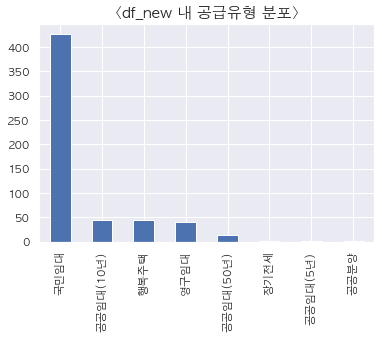

In [304]:
df_new['공급유형'].value_counts().plot(kind='bar', label='train+test')
plt.title('<df_new 내 공급유형 분포>', fontsize=15);

# 공급유형에서 '임대상가'와 '공공임대(분납)'이 다른 유형으로 흡수됨 
# 이 경우는 건물유형이 '주거복합'인 경우임. 

# 이 경우, 상가 // 아파트 공간 수를 따로 계산하여 컬럼을 넣어주어야 할지 고민

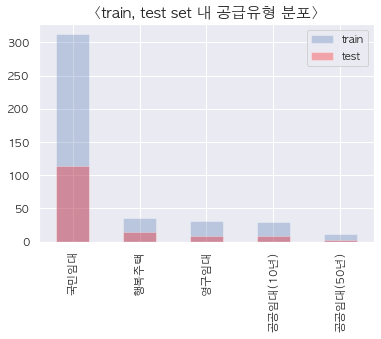

In [277]:
train['공급유형'].value_counts().plot(kind='bar', alpha=0.3, label='train')
test['공급유형'].value_counts().plot(kind='bar', color='red', alpha=0.3, label='test')
plt.legend()
plt.title('<train, test set 내 공급유형 분포>', fontsize=15);

In [156]:
print('=== test set에만 있는 공급유형 ===')
print(set(test['공급유형'])-set(train['공급유형']))

# test set에만 있는 공급유형은 없음! 따라서 test set의 모든 case는 train set으로 훈련 가능.

=== test set에만 있는 공급유형 ===
set()


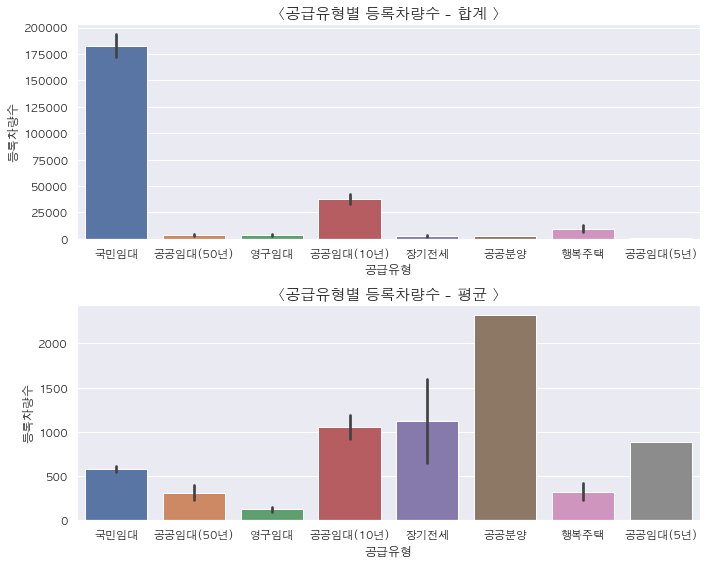

In [303]:
plt.rcParams['font.family']='AppleGothic'
f, ax=plt.subplots(2,1, figsize=(10,8))
sns.barplot(y=df_new['등록차량수'], x=df_new['공급유형'], estimator=sum, ax=ax[0])
ax[0].set_title('<공급유형별 등록차량수 - 합계 >', fontsize=15)

sns.barplot(y=df_new['등록차량수'], x=df_new['공급유형'], ax=ax[1])
ax[1].set_title('<공급유형별 등록차량수 - 평균 >', fontsize=15)
plt.tight_layout()
plt.show();

## 임대보증금과 임대료
- 임대보증금과 임대료가 높은 단지일수록 등록차량수가 많아지는 것으로 나타남  
- 아마 보증금과 임대료가 가구의 소득수준을 반영하는 지표이기 때문일 것임 

In [318]:
df_new[df_new['공급유형']=='행복주택'].head()

,단지코드,총세대수,임대건물구분,지역,공가수,자격유형,공급유형,단지내주차면수,임대보증금,임대료,...,24.99H,46.72H,22.86C,16.94L,26.85L,36.77L,29.19H,39.45H,46.23H,등록차량수
355,C1210,1088.0,아파트,대구광역시,39.0,J,행복주택,773.0,19880000.0,107680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586.0
359,C1685,295.0,아파트,충청북도,28.0,K,행복주택,167.0,40572000.0,21120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,164.0
367,C1659,902.0,아파트,광주광역시,32.0,M,행복주택,635.0,14616000.0,82820.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,416.0
377,C1786,480.0,아파트,강원도,25.0,K,행복주택,338.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,345.0
379,C2570,450.0,아파트,전라남도,14.0,N,행복주택,318.0,12920000.0,71000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0


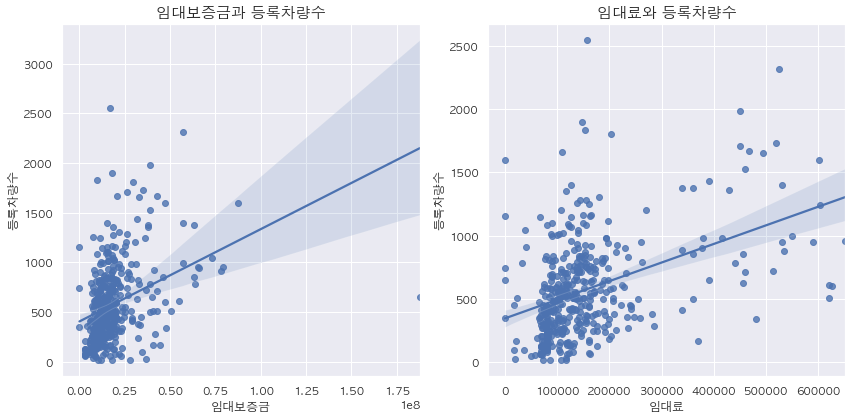

In [324]:
f, ax = plt.subplots(1,2, figsize=(12,6))
sns.regplot(x=df_new['임대보증금'], y=df_new['등록차량수'], ax=ax[0])
ax[0].set_title('임대보증금과 등록차량수', fontsize=15)
sns.regplot(x=df_new['임대료'], y=df_new['등록차량수'], ax=ax[1])
plt.tight_layout()
ax[1].set_title('임대료와 등록차량수', fontsize=15)
plt.show();

## 전용면적   
- 전용면적 * 0.3025 = 통용되는 평수. ex) 전용면적 59 = 24~5평 
- 전용면적 높을수록 세대원 수 많음 = 자동차 수요 ↑ 가능성 존재  
- 25평 정도에 몰려있음. 가구별 자동차 수요 최대 1대일듯  
- 이상치 존재 = 상가 = 드롭X

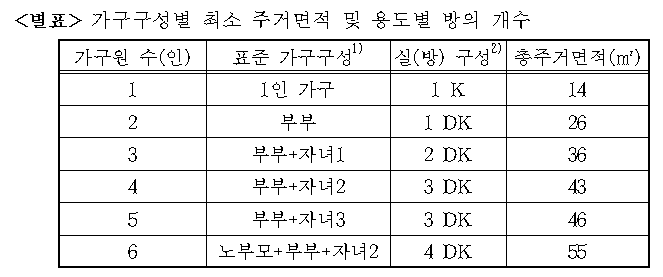

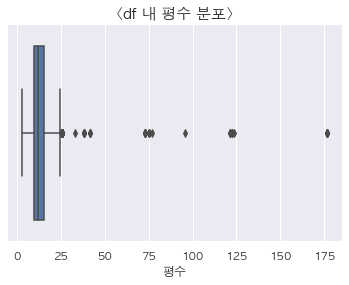

In [305]:
df['평수']=df['전용면적']*0.3025
sns.boxplot(df['평수']); 
plt.title('<df 내 평수 분포>', fontsize=15);

In [169]:
# 이상치 = 상가 
df[df['평수']>50]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,면적_유형,평수
140,C2416,560,주상복합,경상남도,임대상가,317.17,1,0.0,D,0,0,0.0,5.0,154.0,63.0,317.17D,95.943925
197,C1616,1507,주상복합,대전광역시,임대상가,583.40,1,1.0,D,0,0,0.0,2.0,407.0,98.0,583.4D,176.478500
234,C2258,965,주상복합,대전광역시,임대상가,240.22,1,13.0,D,0,0,0.0,3.0,287.0,78.0,240.22D,72.666550
260,C2038,785,주상복합,대전광역시,임대상가,240.22,1,7.0,D,0,0,1.0,10.0,150.0,108.0,240.22D,72.666550
300,C1859,2424,주상복합,대전광역시,임대상가,583.40,1,1.0,D,0,0,1.0,4.0,487.0,116.0,583.4D,176.478500
387,C2135,1116,주상복합,부산광역시,임대상가,240.22,1,10.0,D,0,0,1.0,3.0,262.0,127.0,240.22D,72.666550
416,C2034,1486,주상복합,부산광역시,임대상가,240.22,1,2.0,D,0,0,1.0,3.0,405.0,132.0,240.22D,72.666550
438,C1109,1957,주상복합,부산광역시,임대상가,401.50,1,1.0,D,0,0,1.0,2.0,351.0,313.0,401.5D,121.453750
464,C2289,1527,주상복합,부산광역시,임대상가,583.40,1,2.0,D,0,0,0.0,3.0,240.0,364.0,583.4D,176.478500
496,C2597,1005,주상복합,부산광역시,임대상가,248.56,1,25.0,D,0,0,0.0,2.0,166.0,94.0,248.56D,75.189400


## 총 세대 수, 공가 수  
- 총 세대수 - 등록차량수 : 양의 상관관계  
- 공가수 - 등록차량수 : 약한 양의 상관관계를 보이는데, 이는 총 세대수가 많을수록 공가 수도 많아지기 때문임.  
- 따라서 공가 수는 등록차량수에 유의한 관계가 없다고 보아야 함 

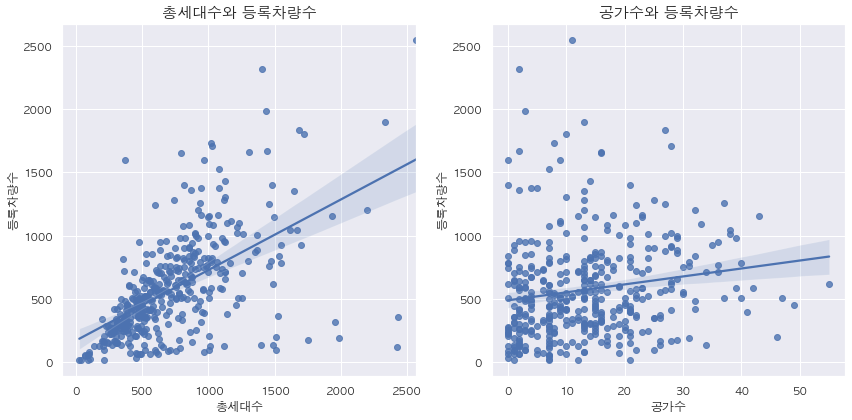

In [326]:
f, ax = plt.subplots(1,2, figsize=(12,6))
sns.regplot(x=df_new['총세대수'], y=df_new['등록차량수'], ax=ax[0])
ax[0].set_title('총세대수와 등록차량수', fontsize=15)
sns.regplot(x=df_new['공가수'], y=df_new['등록차량수'], ax=ax[1])
plt.tight_layout()
ax[1].set_title('공가수와 등록차량수', fontsize=15)
plt.show();

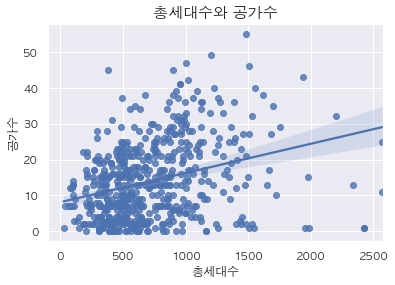

In [328]:
sns.regplot(x=df_new['총세대수'], y=df_new['공가수'])
plt.title('총세대수와 공가수', fontsize=15);

## 자격 유형
- 입주민의 입주자격의 유형  
- 사회보호계층, 주거취약계층, 일반 계층 등을 나타내는 것으로 보임   
- 같은 건물의 같은 전용 면적이라도 자격 유형이 다를 수 있다.  
- 가장 많은 유형은 A > H > C > D > J ... 순서  
- 임대보증금과 임대료 평균으로 자격 유형의 소득 수준을 추정해 봄.  
- 현재 데이터셋에는 추정 소득수준 상위구간 > 하위구간 > 중위구간의 분포를 보임  
  (D의 경우 보증금가 임대료가 기재되지 않은 '상가'이므로 하위구간으로 보기에는 무리가 있음)   
> 추정소득 상위구간 : O, N, A, H  
추정소득 중위구간 : J, G, E=L, B, K, M  
추정소득 하위구간 : I=C, F, D(?)  
   
- 얼추 추정 소득구간 순위와 평균 등록차량수 간 양의 상관관계가 있어보임.  
  H > N > A > B ≓ G > E > M > J > K > L > C   
- 주상복합을 포함했을 때는 D가 가장 많음 

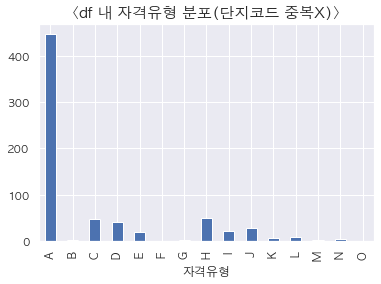

In [309]:
df.groupby('자격유형')['단지코드'].nunique().plot(kind='bar')
plt.title('<df 내 자격유형 분포(단지코드 중복X)>', fontsize=15);

In [191]:
# 자격유형 의미 파악 시도 

print('=== 자격유형 A에 해당하는 공급유형 분포 ===')
print(df[df['자격유형']=='A'].groupby('공급유형')['단지코드'].nunique())
print()
print('=== 자격유형 H에 해당하는 공급유형 분포 ===')
print(df[df['자격유형']=='H'].groupby('공급유형')['단지코드'].nunique())

# 이것으로는 파악 불가능. 보증금과 임대료 평균 순위로 살펴보자. 

=== 자격유형 A에 해당하는 공급유형 분포 ===
공급유형
공공임대(10년)     46
공공임대(50년)     14
공공임대(5년)       1
공공임대(분납)       5
국민임대         384
영구임대           1
장기전세           2
Name: 단지코드, dtype: int64

=== 자격유형 H에 해당하는 공급유형 분포 ===
공급유형
국민임대    50
Name: 단지코드, dtype: int64


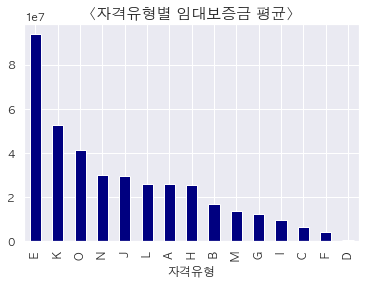

In [310]:
df.groupby('자격유형')['임대보증금'].mean().sort_values(ascending=False).plot(kind='bar', color='navy')
plt.title('<자격유형별 임대보증금 평균>', fontsize=15);

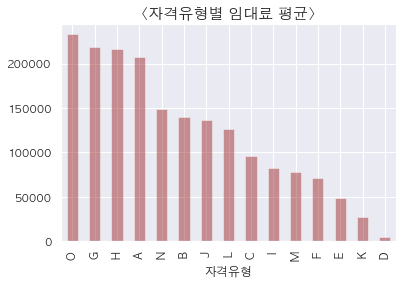

In [311]:
df.groupby('자격유형')['임대료'].mean().sort_values(ascending=False).plot(kind='bar', color='darkred', alpha=0.4)
plt.title('<자격유형별 임대료 평균>', fontsize=15);

In [227]:
# 임대보증금과 임대료 순위를 더하여 전체 순위를 정한다. 
# 순위가 앞 쪽일수록 높은 보증금 및 임대료를 지불한다는 의미 = 소득수준이 괜찮다. 

temp1=df.groupby('자격유형')['임대보증금'].mean().sort_values(ascending=False).index
temp2=df.groupby('자격유형')['임대료'].mean().sort_values(ascending=False).index

temp1=[(idx, item) for idx, item in enumerate(temp1)]
temp2=[(idx, item) for idx, item in enumerate(temp2)]

temp_dic = {} 
for t1 in temp1 : 
    temp_dic[t1[1]]=t1[0]

for t2 in temp2 :
    temp_dic[t2[1]]+=t2[0]

In [257]:
print('=== 평균 임대보증금 및 임대료로 산출한 자격유형별 추정소득 순위 ===')
display(dict(sorted(temp_dic.items(), key=lambda item: item[1])))
print('추정소득 상위구간 : O, N, A, H')
print('추정소득 중위구간 : J, G, E=L, B, K, M')
print('추정소득 하위구간 : I=C, F, D')

=== 평균 임대보증금 및 임대료로 산출한 자격유형별 추정소득 순위 ===


{'O': 2,
 'N': 7,
 'A': 9,
 'H': 9,
 'J': 10,
 'G': 11,
 'E': 12,
 'L': 12,
 'B': 13,
 'K': 14,
 'M': 19,
 'I': 20,
 'C': 20,
 'F': 24,
 'D': 28}

추정소득 상위구간 : O, N, A, H
추정소득 중위구간 : J, G, E=L, B, K, M
추정소득 하위구간 : I=C, F, D


In [255]:
print('=== 자격유형 분포 순위 ===')
df.groupby('자격유형')['단지코드'].nunique().sort_values(ascending=False)

# 추정소득 상위구간 A, H 가 496 
# 추정소득 하위구간 C, D(?) 가 89 
# 추정소득 중위구간 J, E, L + 하위구간 I 가 81 

# D의 경우 임대료와 보증금이 기재되지 않은 임대상가이므로 하위구간이라고 보기에는 조금 무리가 있을 듯. 

=== 자격유형 분포 순위 ===


자격유형
A    446
H     50
C     48
D     41
J     29
I     22
E     20
L     10
K      7
N      5
B      3
G      3
M      2
F      1
O      1
Name: 단지코드, dtype: int64

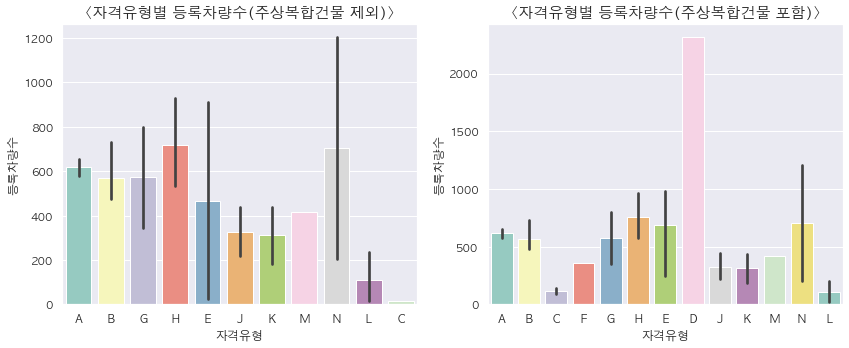

In [336]:
# 일부 단지(주상복합 카테고리)는 복수의 자격유형이 존재함.(그래프 아래의 코드 참고)
# 따라서 주상복합을 제외했을 경우와 포함했을 경우를 나누어 평균 등록차량수를 확인해보기로 함 

temp=df_new[df_new['임대건물구분']!='주상복합']
f, ax=plt.subplots(1,2, figsize=(12,5))
sns.barplot(y=temp['등록차량수'], x=temp['자격유형'], palette='Set3', ax=ax[0])
ax[0].set_title('<자격유형별 등록차량수(주상복합건물 제외)>', fontsize=15)

sns.barplot(y=df_new['등록차량수'], x=df_new['자격유형'], palette='Set3', ax=ax[1])
ax[1].set_title('<자격유형별 등록차량수(주상복합건물 포함)>', fontsize=15)
plt.tight_layout()
plt.show();

# 얼추 추정 소득구간 순위와 평균 등록차량수 간 양의 상관관계가 있는듯? 

In [338]:
print('=== 복수의 자격유형이 존재하는 단지코드 ===')
temp=df[df['공급유형']=='영구임대'].groupby('단지코드')['자격유형'].nunique()>1
temp[temp.values==True]

=== 복수의 자격유형이 존재하는 단지코드 ===


단지코드
C1006    True
C1616    True
C2132    True
C2255    True
C2507    True
Name: 자격유형, dtype: bool

In [349]:
temp_list=temp[temp.values==True].index
for t in temp_list : 
    print(df_new[df_new['단지코드']==t][['단지코드','임대건물구분','공급유형']])
    print()

      단지코드 임대건물구분  공급유형
434  C1006   주상복합  영구임대

     단지코드 임대건물구분  공급유형
25  C1616   주상복합  영구임대

     단지코드 임대건물구분  공급유형
46  C2132   주상복합  영구임대

      단지코드 임대건물구분  공급유형
275  C2255   주상복합  국민임대

      단지코드 임대건물구분  공급유형
345  C2507   주상복합  국민임대



In [354]:
df.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '등록차량수', '면적_유형', '평수'],
      dtype='object')

## 도보 10분 내 지하철역, 버정   
- 버스 정류장과 등록차량수는 약한 양의 상관관계  
- 지하철역 수는 무관함  
- 버정과 등록차량수 간 약한 양의 상관관계를 야기한 요인은 총세대수일 것으로 수론됨. 
  총세대수(=교통수요 높음) -> 버정수, 등록차량수  
- 따라서 지하철역과 버정이 유의한 요인이라고 보기에는 무리가 있음

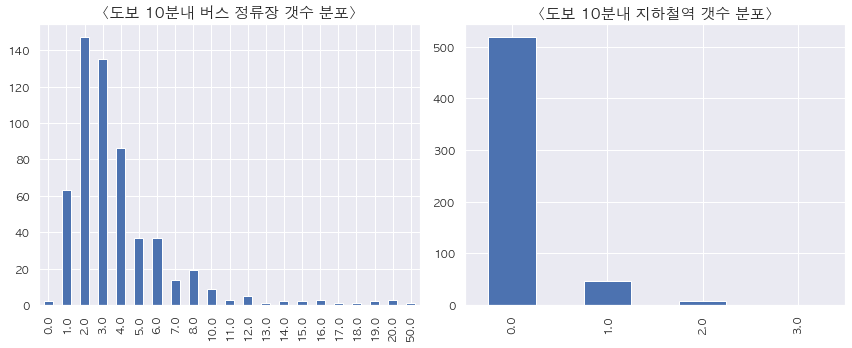

In [372]:
f, ax= plt.subplots(1,2, figsize=(12,5))
df_new['버스'].value_counts().sort_index().plot(kind='bar', ax=ax[0])
ax[0].set_title('<도보 10분내 버스 정류장 갯수 분포>', fontsize=15)
df_new['지하철'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('<도보 10분내 지하철역 갯수 분포>', fontsize=15)
plt.tight_layout()
plt.show();

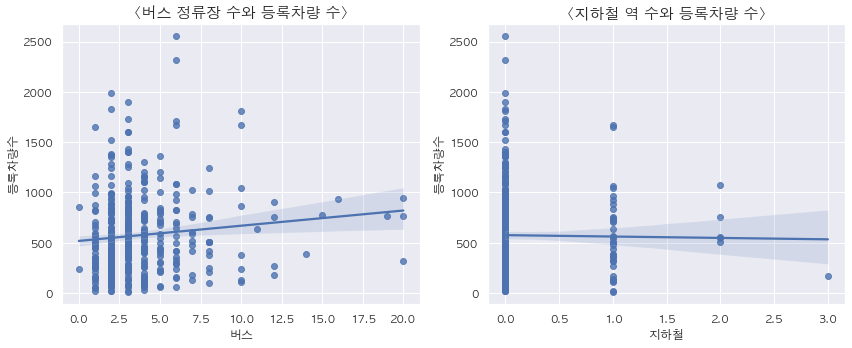

In [375]:
f, ax= plt.subplots(1,2, figsize=(12,5))
sns.regplot(x=df_new['버스'], y=df_new['등록차량수'], ax=ax[0])
ax[0].set_title('<버스 정류장 수와 등록차량 수>', fontsize=15)
sns.regplot(x=df_new['지하철'], y=df_new['등록차량수'], ax=ax[1])
ax[1].set_title('<지하철 역 수와 등록차량 수>', fontsize=15)
plt.tight_layout()
plt.show();

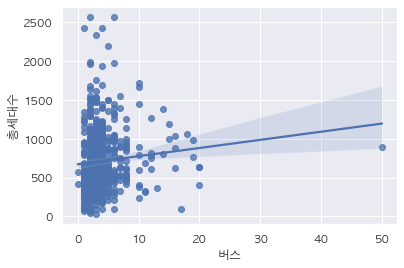

In [380]:
sns.regplot(x=df_new['버스'], y=df_new['총세대수']);

## 단지 내 주차면 수 

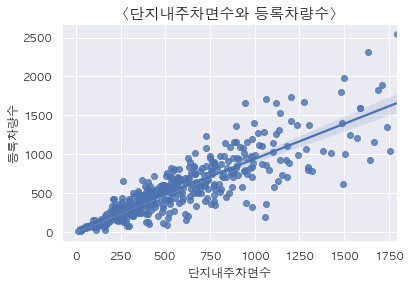

In [384]:
sns.regplot(x=df_new['단지내주차면수'], y=df_new['등록차량수'])
plt.title('<단지내주차면수와 등록차량수>', fontsize=15);

# Basic Modeling 

## Labeling  

In [460]:
drop_cols=['단지코드','공가수','지하철','버스']
target_col=['등록차량수']

In [461]:
train4md=train.drop(drop_cols, 1)
test4md=test.drop(drop_cols, 1)

In [462]:
cat_cols=['임대건물구분','지역','자격유형','공급유형']

lbl = LabelEncoder()
for col in tqdm(cat_cols):   
    temp_df=pd.concat([train4md, test4md])
    
    lbl.fit(temp_df[col])
    train4md[col]=lbl.transform(train4md[col])
    test4md[col]=lbl.transform(test4md[col])
    

100%|██████████| 4/4 [00:00<00:00, 126.22it/s]


## Scaling

In [398]:
from sklearn.preprocessing import StandardScaler

In [463]:
scal_cols=['총세대수', '임대보증금', '임대료', '단지내주차면수' ]

scaler=StandardScaler()
for col in tqdm(scal_cols):
    temp_col=np.array(train4md[col]).reshape(-1,1)
    temp_col2=np.array(test4md[col]).reshape(-1,1)
    scaler.fit(temp_col)
    train4md[col]=scaler.transform(temp_col)
    test4md[col]=scaler.transform(temp_col2)


100%|██████████| 4/4 [00:00<00:00, 371.30it/s]


## X, y split 

In [464]:
X_train = train4md.drop(target_col, 1)
y_train = train4md[target_col]
X_test = test4md

## Basic Model (1) - Random Forest Regressor

In [430]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [465]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

In [470]:
val_scores=[]

for i , (trn_idx, val_idx) in tqdm(enumerate(cv.split(X=X_train, y=y_train))):
    trn_data, trn_target = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    val_data, val_target = X_train.iloc[val_idx], y_train.iloc[val_idx]

    rf_model=RandomForestRegressor(
        random_state=11,
        n_estimators=1000,
        max_depth=100,
        n_jobs=-1).fit(trn_data,trn_target)

    trn_pred = rf_model.predict(trn_data)
    val_pred = rf_model.predict(val_data)
    
    trn_score = mean_absolute_error(trn_target, trn_pred)
    val_score = mean_absolute_error(val_target, val_pred)


    print(f'========== {i} Fold ==========')
    print(f'train log loss : {trn_score},  validation log loss : {val_score} ')
    print()    
          
    val_scores.append(val_score)
    

print(f'Cross Validation Score : {np.mean(val_scores)}')

1it [00:03,  3.36s/it]

========== 0 Fold ==========
train log loss : 49.39821301775147,  validation log loss : 125.26014117647058 



2it [00:06,  3.37s/it]

========== 1 Fold ==========
train log loss : 49.539455621301784,  validation log loss : 137.72689411764708 



3it [00:09,  3.30s/it]

========== 2 Fold ==========
train log loss : 48.2831124260355,  validation log loss : 137.49010588235294 



4it [00:13,  3.46s/it]

========== 3 Fold ==========
train log loss : 49.63894395280236,  validation log loss : 129.9795 



5it [00:17,  3.58s/it]

========== 4 Fold ==========
train log loss : 47.689053097345145,  validation log loss : 142.35365476190475 

Cross Validation Score : 134.56205918767506


**TOO MUCH OVERFITTING!!**

[활용 가능한 외부 데이터]  
- 지역 별 차량 등록 수  
- 지역 별 공영주차장 수  
- 지역 별 전기차 충전소 개소  
- 국민임대,공공임대임. 지역별 중위소득 보다 한단계 낮은 구간의 소득을 활용한다.  
- 지역 별 차량 등록 대수도 포함 가능할 것 같은데  
- 건축물대장 등을 통해 pre-training한 모델을 사용하는 방식도 고려해볼 수 있다.